In [1]:
import matplotlib.pyplot as plt


from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline
from pykeen.models import predict
import pandas as pd
import numpy as np

import statistics
from scipy.ndimage import gaussian_filter1d
import math

In [23]:
def load_dataset(name):
    triple_data = open(name).read().strip()
    data = np.array([triple.split(' ')[:-1] for triple in triple_data.split('\n')])  # removing ' .'
    triple = []
    for t in data:
        t[2] = ' '.join(t[2:])
        t = t[:3]
        triple.append(t)
    triple = np.array(triple)
    tf_data = TriplesFactory.from_labeled_triples(triples=triple)
    return tf_data, triple


def create_model(tf_training, tf_testing, embedding, n_epoch, path):
    results = pipeline(
        training=tf_training,
        testing=tf_testing,
        model=embedding,  # 'TransE',  #'RotatE'
        # Training configuration
        training_kwargs=dict(
            num_epochs=n_epoch,
            use_tqdm_batch=False,
        ),
        # Runtime configuration
        random_seed=1235,
        device='gpu',
        
        #training_loop='LCWA',
        
        training_loop='sLCWA',
        negative_sampler='basic', #'bernoulli', 'basic',
        
        #negative_sampler_kwargs=dict(
        #filtered=True,
        #filterer='bloom',
        #filterer_kwargs=dict(
        #    error_rate=0.0001,
        #)),
    )
    model = results.model
    results.save_to_directory(path + embedding)
    return model, results


def filter_prediction(predicted_heads_df, constraint):
    predicted_heads_df = predicted_heads_df[predicted_heads_df.head_label.str.contains(constraint)]
    predicted_heads_df = reset_index(predicted_heads_df)
    return predicted_heads_df


def filter_by_type(predicted_heads, triple_data, entity_type):
    list_entity = predicted_heads.head_label
    entity = []
    for s in list_entity:
        for triple in triple_data:
            b = [s, '<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>', entity_type] == triple
            if np.all(b):
                entity.append(s)
                break
    predicted_heads = predicted_heads.loc[predicted_heads.head_label.isin(entity)]
    predicted_heads = reset_index(predicted_heads)
    return predicted_heads, entity


def get_threshold(predicted_heads, percentile):
    score_values = predicted_heads.score.values
    threshold = np.percentile(score_values, percentile)
    threshold_index = predicted_heads.loc[predicted_heads.score > threshold].shape[0]
    print(threshold, threshold_index)
    return threshold, threshold_index


def get_inflection_point(score_values):
    # standard deviation
    stdev = statistics.stdev(score_values)
    # smooth
    smooth = gaussian_filter1d(score_values, stdev)
    # compute second derivative
    smooth_d2 = np.gradient(np.gradient(smooth))
    # find switching points
    infls = np.where(np.diff(np.sign(smooth_d2)))[0]
    if len(infls) == 1:
        return infls[0]
    if len(infls) == 0:
        return len(score_values)
    # middle inflection point
    m_infls = infls[math.ceil(len(infls) / 2)]
    return m_infls


def get_precision(predicted_heads, inflection_index):
    tp_fp = predicted_heads.iloc[0:inflection_index + 1]
    tp = tp_fp.loc[tp_fp.in_training == True].shape[0]
    prec = tp / tp_fp.shape[0]
    return prec, tp


def get_recall(predicted_heads, tp):
    tp_fn = predicted_heads.loc[predicted_heads.in_training == True].shape[0]
    rec = tp / tp_fn
    return rec


def get_f_measure(precision, recall):
    f_measure = 2 * (precision * recall) / (precision + recall)
    return f_measure


def reset_index(predicted_heads):
    predicted_heads.reset_index(inplace=True)
    predicted_heads.drop(columns=['index'], inplace=True)
    return predicted_heads


def compute_metrics(predicted_heads, cut_index):
    precision, tp = get_precision(predicted_heads, cut_index)
    recall = get_recall(predicted_heads, tp)
    f_measure = get_f_measure(precision, recall)
    return pd.DataFrame(columns=['precision', 'recall', 'f_measure'],
                        data=[[precision,recall,f_measure]], index=['MuRe'])


def plot_score_value(score_values, title):
    plt.plot(score_values)
    plt.xlabel("Entities")
    plt.ylabel("Score")
    plt.title(title)
    plt.show()

#### Load dataset I4.0 KG

In [3]:
tf_data, triple_data = load_dataset('sto-enriched-relatedTo.nt')
print('The first two triples:\n', triple_data[:2])
tf_data

/tmp/ipykernel_3261/3217077378.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array([triple.split(' ')[:-1] for triple in triple_data.split('\n')])  # removing ' .'


The first two triples:
 [['<http://www.w3.org/1999/02/22-rdf-syntax-ns#value>'
  '<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>'
  '<http://www.w3.org/2002/07/owl#AnnotationProperty>']
 ['<http://www.w3.org/2001/XMLSchema#gYear>'
  '<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>'
  '<http://www.w3.org/2000/01/rdf-schema#Datatype>']]


TriplesFactory(num_entities=8947, num_relations=107, num_triples=43475, inverse_triples=False)

### Create training and testing set

In [4]:
training, testing = tf_data.split(random_state=1234)

### Buildind the model

In [15]:
model, results = create_model(training, testing, 'RotaTe', 10, 'results_I4.0/')

Training epochs on cuda:   0%|          | 0/10 [00:00<?, ?epoch/s]

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=256.


Evaluating on cuda:   0%|          | 0.00/8.70k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 2.57s seconds


### Evaluating the Results

<AxesSubplot:title={'center':'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

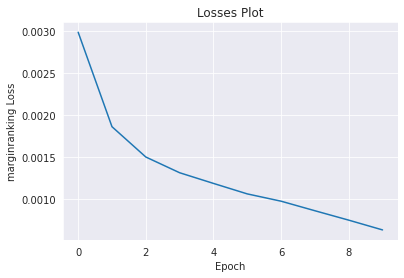

In [16]:
results.plot_losses()

- adjusted mean rank is between [0, 2]. Lower is better.
- mean rank is a positive integer, with a bound based on the number of entities. Lower is better!
- hits@k is reported between [0, 1] and interpreted as a percentage. Higher is better!

In [17]:
results.metric_results.to_df()

,Side,Type,Metric,Value
0,tail,pessimistic,hits_at_1,0.008626
1,tail,pessimistic,hits_at_3,0.023117
2,tail,pessimistic,hits_at_5,0.040483
3,tail,pessimistic,hits_at_10,0.097757
4,tail,pessimistic,arithmetic_mean_rank,241.127545
...,...,...,...,...
136,both,realistic,rank_std,785.478068
137,both,realistic,rank_var,616975.795499
138,both,realistic,rank_mad,31.000000
139,both,realistic,adjusted_arithmetic_mean_rank,0.060261


## Link Prediction

The predictions are ordered by their scores.
All interaction functions in PyKEEN have been implemented such that the higher the score (or less negative the score), the more likely a triple is to be true.

### Predict links (Head prediction)

In [18]:
#e1 = '<https://w3id.org/i40/sto#hasClassification>'
#e2 = '<https://w3id.org/i40/rami#Safety>'
e1 = '<https://w3id.org/i40/sto#relatedTo>'
e2 = '<https://w3id.org/i40/sto#IEC_61850_P7_S3_E1>'
predicted_heads = predict.get_head_prediction_df(model, e1, e2, triples_factory=tf_data)
predicted_heads

,head_id,head_label,score,in_training
5730,5730,<http://www.w3.org/2002/07/owl#AnnotationPrope...,-3.145916,False
6445,6445,<https://w3id.org/i40/sto#BPMN>,-3.155034,True
6800,6800,<https://w3id.org/i40/sto#IBM>,-3.162925,False
3264,3264,"""pdf""",-3.183716,False
6988,6988,<https://w3id.org/i40/sto#IEC_61850_P7_S1_E1>,-3.230472,True
...,...,...,...,...
3284,3284,"""x-road Section""@en",-5.574364,False
1509,1509,"""IEC 61970-452:2015 ""@en",-5.590561,False
991,991,"""Enterprise Integration deals primarily with s...",-5.610683,False
3282,3282,"""x-road Deplyoment View""@en",-5.629702,False


### Filter the prediction by the head 'sto'

In [19]:
predicted_heads = filter_prediction(predicted_heads, '<https://w3id.org/i40/sto#')
predicted_heads

/home/rivas/.local/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,head_id,head_label,score,in_training
0,6445,<https://w3id.org/i40/sto#BPMN>,-3.155034,True
1,6800,<https://w3id.org/i40/sto#IBM>,-3.162925,False
2,6988,<https://w3id.org/i40/sto#IEC_61850_P7_S1_E1>,-3.230472,True
3,7119,<https://w3id.org/i40/sto#ISO_10303>,-3.240358,True
4,7165,<https://w3id.org/i40/sto#ISO_27036>,-3.240857,True
...,...,...,...,...
1294,6612,<https://w3id.org/i40/sto#Energy_management>,-5.208713,False
1295,7517,<https://w3id.org/i40/sto#ServiceDescriptions>,-5.212553,False
1296,7418,<https://w3id.org/i40/sto#ProjectManager>,-5.242934,False
1297,6793,<https://w3id.org/i40/sto#GeospatialQuery>,-5.345814,False


### Filter by entity type 'Standard'. (it take some minutes)

In [23]:
predicted_heads, entity = filter_by_type(predicted_heads, triple_data, '<https://w3id.org/i40/sto#Standard>')
predicted_heads

/tmp/ipykernel_1401/854752121.py:56: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  b = [s, '<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>', entity_type] == triple


KeyboardInterrupt: 

### Plot of entities predicted score values

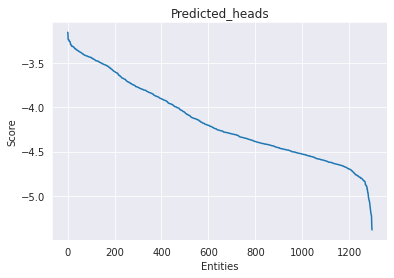

In [20]:
score_values = predicted_heads.score.values
plt.plot(score_values)
plt.xlabel("Entities")
plt.ylabel("Score")
plt.title("Predicted_heads")
plt.show()

### Strategy 'inflection point'

In [21]:
inflection_index = get_inflection_point(predicted_heads.score.values)
compute_metrics(predicted_heads, inflection_index)

,precision,recall,f_measure
MuRe,0.226994,1.0,0.37


### Strategy 'threshold'

In [26]:
threshold, threshold_index = get_threshold(predicted_heads, 90)
compute_metrics(predicted_heads, threshold_index)

-3.481215763092041 130


,precision,recall,f_measure
MuRe,0.900763,0.797297,0.845878


In [13]:
#e1 = '<https://w3id.org/i40/sto#ISO_24760>'
#e1 = '<https://w3id.org/i40/sto#IEC_62541>'
#e1 = '<https://w3id.org/i40/sto#ISO_18629>'
#e1 = '<https://w3id.org/i40/sto#IEC_62237>'
#e1 = '<https://w3id.org/i40/sto#ISO_15746>'
e1 = '<https://w3id.org/i40/sto#ISO_TS_14649-201>'
e2 = '<https://w3id.org/i40/sto#hasClassification>'
predicted_tails = predict.get_tail_prediction_df(model, e1, e2, triples_factory=tf_data)
predicted_tails

,tail_id,tail_label,score,in_training
7442,7442,<https://w3id.org/i40/sto#RAMIFieldDevice>,-0.918467,False
7438,7438,<https://w3id.org/i40/sto#RAMIControlDevice>,-0.991668,False
7453,7453,<https://w3id.org/i40/sto#RAMIProduct>,-1.013164,True
7455,7455,<https://w3id.org/i40/sto#RAMIStation>,-1.085429,False
7099,7099,<https://w3id.org/i40/sto#IIRASecurity>,-1.116534,False
...,...,...,...,...
5734,5734,<http://www.w3.org/2002/07/owl#NamedIndividual>,-5.769360,False
5699,5699,<http://www.ontology-of-units-of-measure.org/r...,-5.775720,False
8011,8011,<https://www.w3.org/ns/oaSpecificResource>,-6.327998,False
8012,8012,<https://www.w3.org/ns/oaXPathSelector>,-6.331574,False


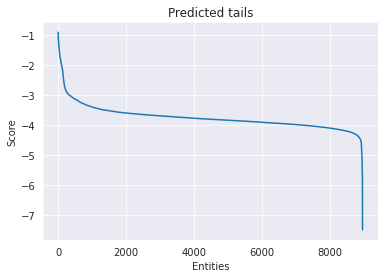

In [24]:
score_values = predicted_tails.score.values
plot_score_value(score_values, "Predicted tails")

In [28]:
predicted_tails = reset_index(predicted_tails)
compute_metrics(predicted_tails, 5)

,precision,recall,f_measure
MuRe,0.166667,0.142857,0.153846
